
# Tarea N°02
## Instrucciones
1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.

**Nombre**: Javier Díaz González

**Rol**: 201710528-3

2.- Debes pushear este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:

- Soluciones
- Código
- Que Binder esté bien configurado.
- Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
np.unique(digits_dict["target"])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [6]:
digits.isna().all().unique()

array([False])

### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

Veamos si hay valores nulos:

In [7]:
digits.dtypes.unique()

array([dtype('int32')], dtype=object)

Separamos los predictores en categóricos y continuos:

In [8]:
cont_predictor_names = [] # continuous variables
cat_predictor_names = [] # categorical variables

for column in digits.columns[:64]:
    if digits[column].dtype == 'object':
        cat_predictor_names.append(column)
    else:
        cont_predictor_names.append(column)

print(cont_predictor_names)
print(cat_predictor_names)

['c00', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63']
[]


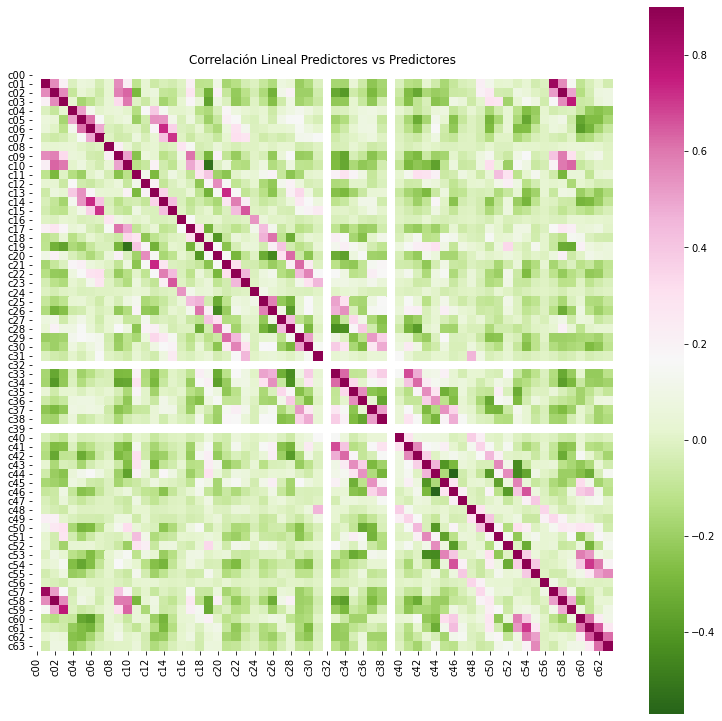

In [9]:
predictor_names = cont_predictor_names
n_show = min(len(predictor_names),70)

corrmat = digits[predictor_names[:n_show]].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corrmat, vmax=.9, square=True, ax=ax, cmap='PiYG_r')
ax.set_title("Correlación Lineal Predictores vs Predictores")
plt.show()

Podemos ver que la correlación entre los predictores se tiene una diferencia de 10 posiciones (línea sobre la diagonal principal). Además se ven algunos clusters de predictores muy correlacionados. Para los predictores 'c00','c32','c39' se tienen líneas blancas dado que los `values` de cada columna son ceros, por ende en la diagonal principal se tiene color blanco, pues es el valor esperado de los datos.

In [10]:
targets_count = []

for i in range(len(np.unique(digits['target'].values))):
    print(f'clase {i}')
    print('Descripcion:')
    print(digits[digits['target']==i].describe())
    print('')
    targets_count.append(tuple([i,digits[digits['target']==i].shape[0]]))

print(f"Cantidad de datos asociados a cada clase: {targets_count}")

clase 0
Descripcion:
         c00         c01         c02         c03         c04         c05  \
count  178.0  178.000000  178.000000  178.000000  178.000000  178.000000   
mean     0.0    0.022472    4.185393   13.095506   11.297753    2.926966   
std      0.0    0.211400    2.946684    2.246625    3.417485    3.232996   
min      0.0    0.000000    0.000000    5.000000    0.000000    0.000000   
25%      0.0    0.000000    2.000000   12.000000    9.000000    1.000000   
50%      0.0    0.000000    4.000000   13.000000   12.000000    2.000000   
75%      0.0    0.000000    6.000000   15.000000   14.000000    5.000000   
max      0.0    2.000000   12.000000   16.000000   16.000000   14.000000   

              c06    c07    c08         c09  ...    c55    c56         c57  \
count  178.000000  178.0  178.0  178.000000  ...  178.0  178.0  178.000000   
mean     0.033708    0.0    0.0    0.887640  ...    0.0    0.0    0.005618   
std      0.180985    0.0    0.0    1.778327  ...    0.0    0

         c00    c01         c02         c03         c04         c05  \
count  181.0  181.0  181.000000  181.000000  181.000000  181.000000   
mean     0.0    0.0    0.453039    7.055249   11.497238    2.011050   
std      0.0    0.0    1.415884    4.862240    4.090129    3.056848   
min      0.0    0.0    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.0    0.000000    3.000000    9.000000    0.000000   
50%      0.0    0.0    0.000000    7.000000   13.000000    0.000000   
75%      0.0    0.0    0.000000   11.000000   15.000000    3.000000   
max      0.0    0.0   11.000000   16.000000   16.000000   15.000000   

              c06         c07    c08         c09  ...    c55    c56  \
count  181.000000  181.000000  181.0  181.000000  ...  181.0  181.0   
mean     0.209945    0.127072    0.0    0.060773  ...    0.0    0.0   
std      1.278067    1.197398    0.0    0.449268  ...    0.0    0.0   
min      0.000000    0.000000    0.0    0.000000  ...    0.0    0.0   
25%  

         c00         c01         c02         c03         c04         c05  \
count  180.0  180.000000  180.000000  180.000000  180.000000  180.000000   
mean     0.0    0.144444    5.683333   11.833333   11.255556    5.944444   
std      0.0    0.462230    4.036807    4.256444    3.654220    5.284871   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000000    2.000000   10.750000    9.000000    1.000000   
50%      0.0    0.000000    6.000000   13.000000   12.000000    5.000000   
75%      0.0    0.000000    9.000000   15.000000   14.000000   10.250000   
max      0.0    4.000000   15.000000   16.000000   16.000000   16.000000   

              c06         c07    c08         c09  ...         c55    c56  \
count  180.000000  180.000000  180.0  180.000000  ...  180.000000  180.0   
mean     1.572222    0.122222    0.0    2.433333  ...    0.111111    0.0   
std      3.786230    1.141672    0.0    2.824672  ...    0.548119    0.0   
min      0.

In [11]:
digits_group = digits.groupby('target')
digits_group.describe(include='all').T

target         0      1      2      3      4      5      6      7      8  \
c00 count  178.0  182.0  177.0  183.0  181.0  182.0  181.0  179.0  174.0   
    mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
c63 min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    75%      0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0   
    max      0.0   16.0   16.0    8.0    0.0    0.0    6.0    0.0    2.0   

target         9  
c00 count  180.0  
    mean     0.0  
    std      0.0  
    min      0.0  
    25%      0.0  
...          ...  
c63 min      0.0  
    25%      0.0  
    50%      0.0  
    75%      0.0  
    max      3.0  

[512 rows x 10 columns]

In [12]:
print(f'Cantidad de memoria usada en el DataFrame: {digits.memory_usage(index=True,deep=True).sum()} bytes')

Cantidad de memoria usada en el DataFrame: 467348 bytes


Veamos cómo están distribuidos los datos:

In [13]:
digits['target']

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int32

Distribución de los datos:

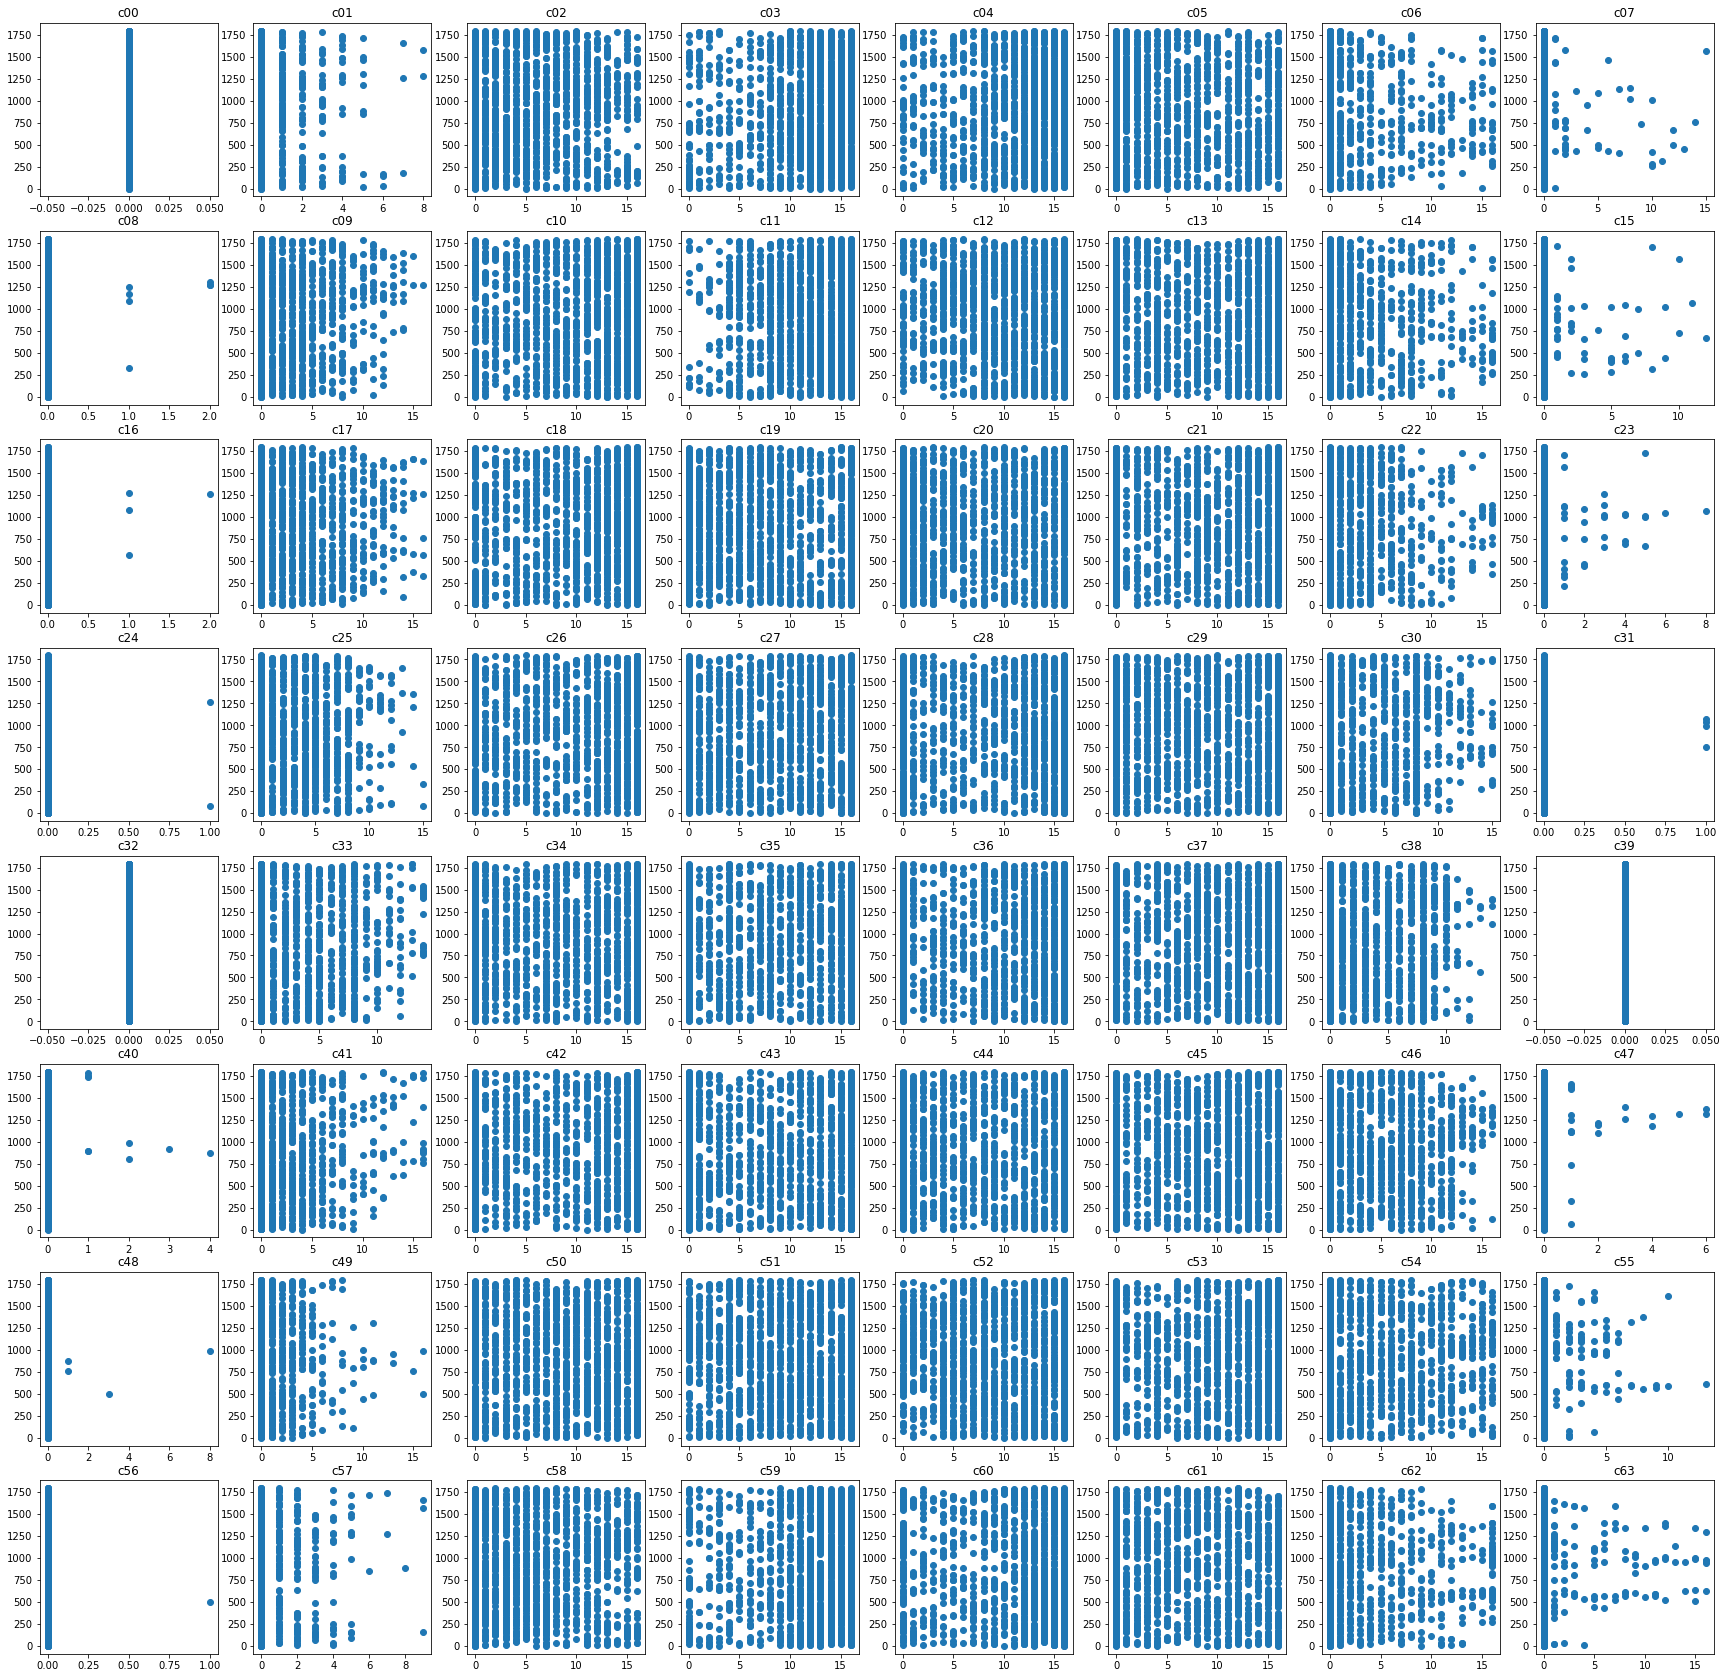

In [14]:
y = [i for i in range(len(digits))]
fig = plt.figure(figsize = (30,30))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.scatter(digits[digits.columns[i]],y)
    plt.title(digits.columns[i])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [15]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

In [16]:
digits_dict['images'].shape

(1797, 8, 8)

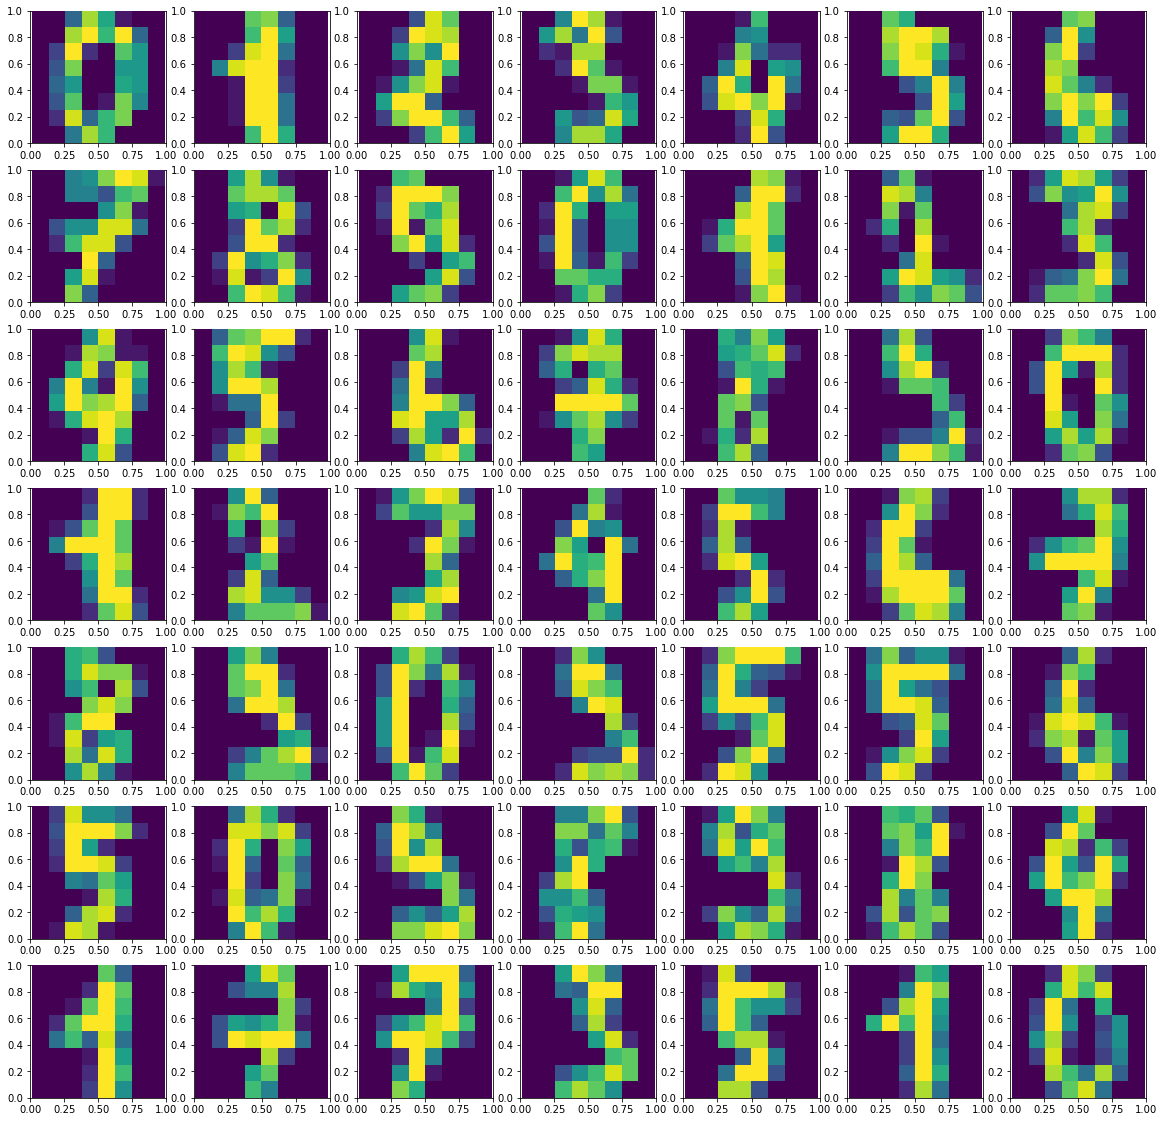

In [17]:
nx, ny = 7, 7
fig, axs = plt.subplots(nx, ny, figsize=(20, 20))
for i in range(1, nx*ny+1):
    img = digits_dict['images'][i-1]
    fig.add_subplot(nx, ny, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [18]:
X = digits.drop(columns="target").values
y = digits["target"].values

from metrics_classification import summary_metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

print(f'numero de filas train set: {len(X_train)}')
print(f'numero de filas test set: {len(X_test)}')

numero de filas train set: 1203
numero de filas test set: 594


* __Regresión Logística__

In [19]:
#Modelo de Regresión logística usando GridsearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

#Selección de hiperparámetros
params_logreg = {
          'penalty' : ['l1', 'l2'],
          'C' : [100, 10 , 1, 0.1, 0.01],
          'class_weight' : ['balanced', None],
          'solver' : ['liblinear'],
          }

logreg_model = LogisticRegression()

logreg_gridsearchcv = GridSearchCV(estimator = logreg_model, param_grid = params_logreg, cv = 10)

start_time = time.time()

logreg_grid_result = logreg_gridsearchcv.fit(X_train, y_train)


print("--- %s segundos ---" % (time.time() - start_time))

--- 45.86793041229248 segundos ---


In [20]:
print("Mejor: %f usando %s" % (logreg_grid_result.best_score_, logreg_grid_result.best_params_))

Mejor: 0.969256 usando {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [21]:
y_pred = logreg_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9411,0.9402,0.9397,0.9396


In [22]:
from sklearn.metrics import confusion_matrix

print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,61,0,0,0,0,0,0,0,0,0
1,0,55,0,1,0,0,1,0,3,1
2,0,0,55,0,0,0,0,0,0,0
3,0,0,0,62,0,2,0,2,1,1
4,0,1,0,0,55,0,0,0,0,3
5,1,1,0,0,0,59,0,0,0,2
6,0,0,0,0,0,1,65,0,1,0
7,0,0,0,0,0,0,0,56,0,1
8,0,5,0,1,0,1,0,0,45,0
9,1,0,0,1,0,0,0,1,2,46


* __K-nearest neighbour__

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#Selección de hiperparámetros
params_knn = {
          'n_neighbors' : [3, 5, 11, 19],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan'],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

knn_gridsearchcv = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

knn_grid_result = knn_gridsearchcv.fit(X_train, y_train)

print("--- %s segundos ---" % (time.time() - start_time))

--- 12.451930522918701 segundos ---


In [24]:
print("Mejor: %f usando %s" % (knn_grid_result.best_score_, knn_grid_result.best_params_))

Mejor: 0.986687 usando {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [25]:
y_pred = knn_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9815,0.9811,0.9804,0.9805


In [26]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,61,0,0,0,0,0,0,0,0,0
1,0,61,0,0,0,0,0,0,0,0
2,0,0,55,0,0,0,0,0,0,0
3,0,0,0,65,0,0,0,1,1,1
4,0,0,0,0,56,0,0,1,1,1
5,0,0,0,0,0,62,0,0,0,1
6,0,0,0,0,0,0,67,0,0,0
7,0,0,0,0,0,0,0,57,0,0
8,0,2,0,0,0,0,0,0,50,0
9,0,0,0,0,0,0,0,1,1,49


* __Linear Discriminant Analysis__

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Parameter tuning with GridSearchCV 

#######################
### LDA  - svd
#######################

model_lda = LinearDiscriminantAnalysis(solver='svd', )#Calculamos el LDA con la matriz SVD
params_lda = {
    'n_components': (0,5,1),
    'store_covariance' :(True, False),
                   }
# Usando GridSearch obtenermos el mejor estimador posible
lda_gridsearchcv = GridSearchCV(
    estimator = model_lda,
    param_grid = params_lda,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

start_time = time.time()

lda_grid_result = lda_gridsearchcv.fit(X_train, y_train)

print("--- %s segundos ---" % (time.time() - start_time))

--- 2.1141529083251953 segundos ---


In [28]:
print("Mejor: %f usando %s" % (lda_grid_result.best_score_, lda_grid_result.best_params_))

Mejor: 0.950947 usando {'n_components': 0, 'store_covariance': True}


In [29]:
y_pred = lda_gridsearchcv.predict(X_test)
summary_metrics(pd.DataFrame(data={'y':y_test, 'yhat':y_pred}))

,accuracy,recall,precision,fscore
0,0.9428,0.9405,0.9413,0.9405


In [30]:
print('Matriz de confusion:')
pd.DataFrame(data=confusion_matrix(y_test,y_pred))

Matriz de confusion:


,0,1,2,3,4,5,6,7,8,9
0,60,0,0,0,0,0,1,0,0,0
1,0,57,0,0,0,0,0,0,1,3
2,0,0,55,0,0,0,0,0,0,0
3,0,0,0,64,0,1,0,0,1,2
4,0,1,0,0,55,0,0,0,2,1
5,0,0,0,0,0,60,0,0,1,2
6,0,1,0,0,0,0,65,0,0,1
7,0,0,0,0,0,0,0,56,0,1
8,0,7,0,0,0,1,0,0,44,0
9,0,0,0,1,0,1,0,1,4,44


Comparando las métricas y las matrices de confusión, podemos decir que el modelo KNN se ajusta mejor a los datos y que LDA con LogReg se ajustan de manera similar. En cuanto al tiempo que se demora cada modelo, LDA es el más veloz, seguido por KNN y luego por LogReg. El orden de precisión en la que se diferencian los modelos corresponde a $10^{-2}$, por lo que si bien KNN demora mucho más que LDA, es un tiempo que estamos dispuesto a perder para asegurar la precisión del modelo.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

* __Cross validation:__ _KNN_

In [31]:
from sklearn.model_selection import cross_val_score

precision = cross_val_score(estimator=knn_gridsearchcv,
                            X=X_train,
                            y=y_train,
                            cv=10)

precision = [round(x,2) for x in precision]
print('Precisiones: {} '.format(precision))

from IPython.display import display, Math
(display(Math(r'precision\_promedio: {0: .3f} \pm {1: .3f}'.format(np.mean(precision),np.std(precision)))))

Precisiones: [0.98, 1.0, 0.99, 0.98, 0.99, 0.98, 0.98, 0.98, 0.99, 0.99] 


<IPython.core.display.Math object>

* __Curva de Validación:__

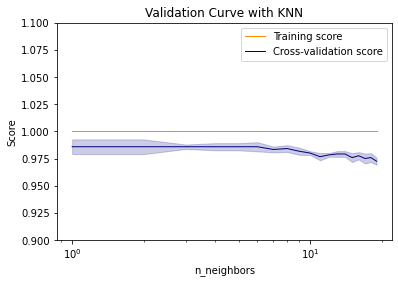

In [32]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1,20,1)

# Usamos los mejores hiperparametros 
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(weights = 'distance',metric = 'euclidean'), X_train, y_train, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.9, 1.1)

lw = 1
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)

plt.semilogx(param_range, test_scores_mean, 
             label="Cross-validation score",color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)

plt.legend(loc="best")

plt.show()

Es importante analizar esta curva, pues nos entrega información sobre si estamos en presencia de `overfitting` o no. En este caso, el modelo K-nearest neighbour "aprende" muy bien el conjunto de entrenamiento. Pero por el crossvalidation sabemos que estrictamente el modelo no está memorizando, sino que este score se obtiene únicamente por las características del train set. El máximo como ya hemos visto se alcanza con 3 vecinos (lo cual es un poco menos que lo usual empíricamente, 5 o 10). Luego del máximo la curva de la validación cruzada comienza a descender y el GAP entre ambas curvas se va haciendo más grande.

* __Curva AUC-ROC:__
Fuente: [ROC example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

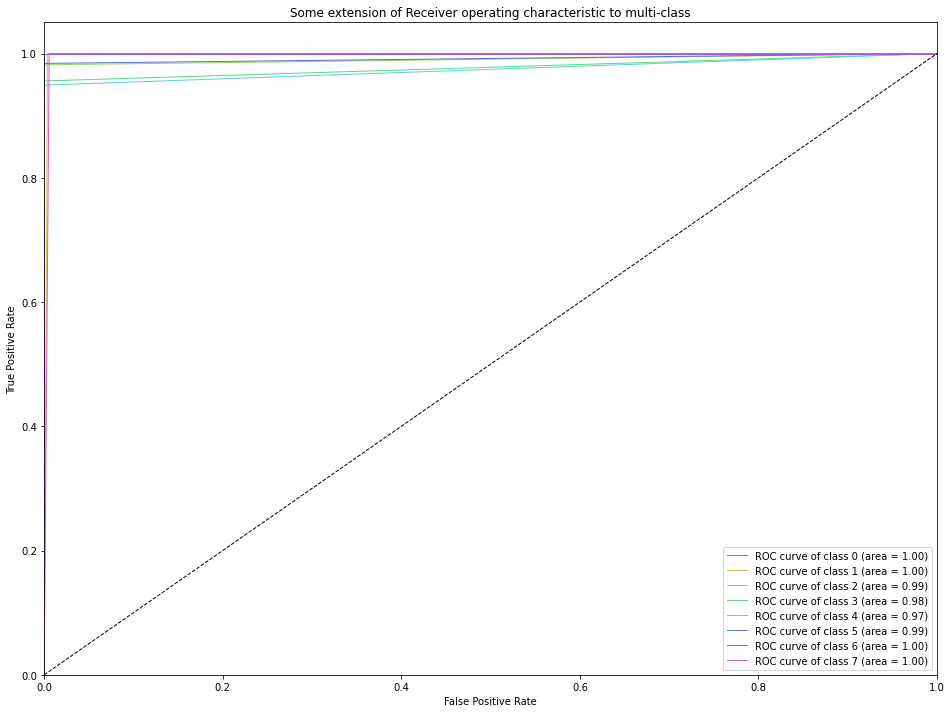

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from sklearn.metrics import roc_auc_score

y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

classifier = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=3, weights='distance')
y_score = classifier.fit(X_train, y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

import sys
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams["figure.figsize"] = (16,12)
colors = sns.color_palette("hls", 8)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

La curva ROC-AUC nos indica que el modelo predice bastante bien.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [34]:
X = pd.DataFrame(digits.drop(columns="target").drop(['c00','c32','c39'], axis=1) )
y = digits["target"]

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k = 15  # número de atributos a seleccionar
columnas = list(X.columns.values)
selected_predictors = SelectKBest(f_classif, k=k).fit(X, y)
support_predictors = selected_predictors.get_support()
atributes = [columnas[i] for i in list(support_predictors.nonzero()[0])]
print(atributes)

['c10', 'c13', 'c20', 'c21', 'c26', 'c28', 'c30', 'c33', 'c34', 'c36', 'c42', 'c43', 'c46', 'c60', 'c61']


In [36]:
# ajustar modelo utilizando PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(X)
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(X)
selected_predictors = SelectKBest(f_classif, k=k).fit(X, y)

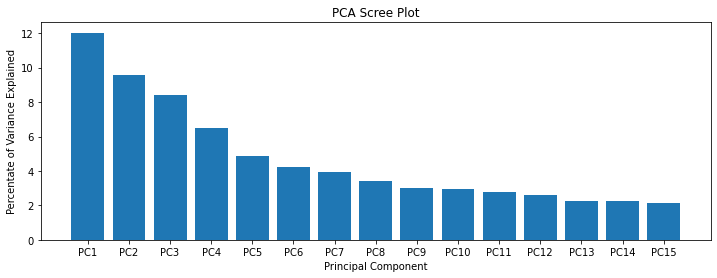

In [37]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns=[]
for i in range(1, 16):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(f'PC{i}')
    columns

plt.figure(figsize=(12,4))
plt.bar(x= range(1,16), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

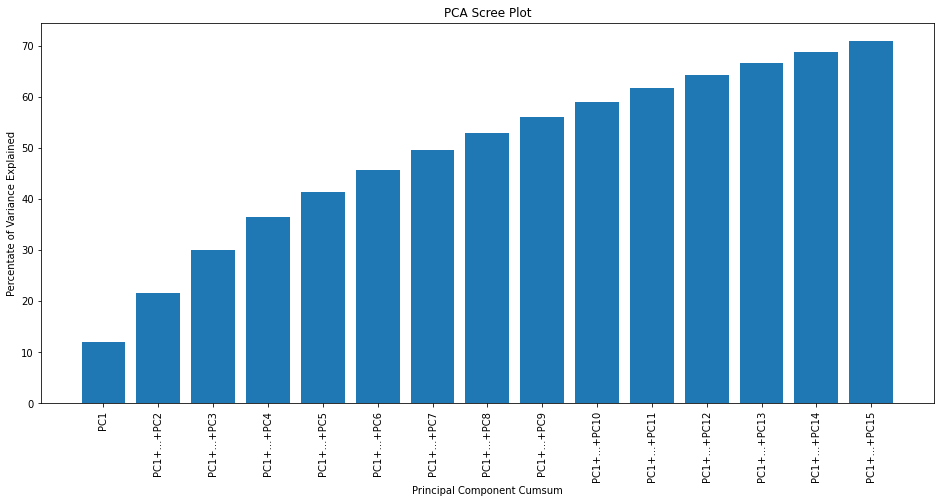

In [38]:
percent_variance_cum = np.cumsum(percent_variance)
columns = []
for i in range(1, 16):
    if i == 1:
        columns.append(f'PC{i}')
    else:
        columns.append(columns[0] + f'+...+PC{i}')
columns

plt.figure(figsize=(16,7))
plt.bar(x= range(1,16), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xticks(x= range(1,16), rotation='vertical')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

In [39]:
X_k = pd.DataFrame(X,columns=columnas)[atributes]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_k, y, test_size=0.33, random_state=2)

precision = cross_val_score(estimator=knn_gridsearchcv,X=X_train2,y=y_train2,cv=10)

precision = [round(x,2) for x in precision]
print('Precisiones: {} '.format(precision))
display(Math(r'precision\_promedio: {0: .3f} \pm {1: .3f}'.format(np.mean(precision),np.std(precision))))

Precisiones: [0.92, 0.99, 0.98, 0.94, 0.96, 0.97, 0.92, 0.96, 0.98, 0.98] 


<IPython.core.display.Math object>

In [40]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(principalComponents, y, test_size=0.33, random_state=2)

classifier = KNeighborsClassifier(weights = 'distance',metric = 'euclidean', n_neighbors = 3)

precision = cross_val_score(estimator=knn_gridsearchcv,X=X_train3,y=y_train3,cv=10)

precision = [round(x,2) for x in precision]
print('Precisiones: {} '.format(precision))
display(Math(r'precision\_promedio: {0: .3f} \pm {1: .3f}'.format(np.mean(precision),np.std(precision))))

Precisiones: [0.97, 0.99, 0.98, 0.97, 0.98, 0.97, 0.98, 0.96, 0.97, 0.99] 


<IPython.core.display.Math object>

In [41]:
#Método K-Nearest Neighbours Seleccionando atributos

#Selección de hiperparámetros
params_knn = {
          'n_neighbors' : [3, 5, 11, 19],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan'],
          'algorithm' : ['auto','ball_tree', 'kd_tree']
          }

model_knn = KNeighborsClassifier()

knn_gridsearchcv = GridSearchCV(estimator = model_knn, param_grid = params_knn, cv = 10)

start_time = time.time()

knn_grid_result = knn_gridsearchcv.fit(X_train2, y_train2)

print('KNN with GridSearch and atributes')
print("--- %s segundos ---" % (time.time() - start_time))

#Método K-Nearest Neighbours extrayendo atributos y usando PCA

start_time = time.time()

knn_grid_result_2 = knn_gridsearchcv.fit(X_train3, y_train3)

print('')
print('KNN with PCA')
print("--- %s segundos ---" % (time.time() - start_time))

KNN with GridSearch and atributes
--- 5.951641321182251 segundos ---

KNN with PCA
--- 4.404240131378174 segundos ---


Como resultado tenemos que el tiempo mejor considerablemente respecto a tener toda la data. No obstante, baja un poco la precisión, pero es un costo que estaríamos a priori dispuestos a pagar, pues el tiempo de ejecución se redujo casi a la mitad y la precisión sólo varió en a lo más 2%.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [42]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = np.array(y_pred)[mask]
    
    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    fix = X_aux.shape[0]
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index < fix:
                data  = X_aux[index, :].reshape(8,8)
                label_pred = str(int(y_aux_pred[index]))
                label_true = str(int(y_aux_true[index]))
                ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
                ax[i][j].text(0, 0, label_pred,
                              horizontalalignment='center',
                              verticalalignment='center',
                              fontsize=10,
                              color=color)
                ax[i][j].text(7, 0, label_true,
                              horizontalalignment='center',
                              verticalalignment='center',
                              fontsize=10,
                              color='blue')
                ax[i][j].get_xaxis().set_visible(False)
                ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

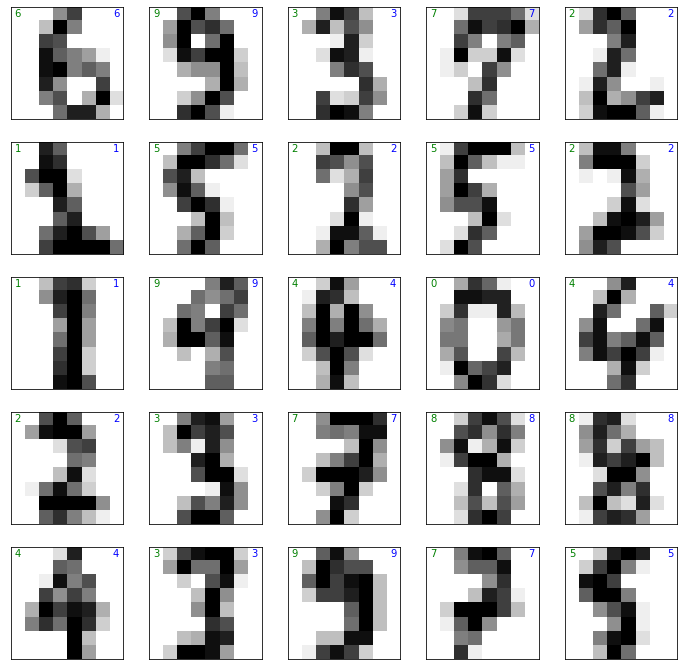

In [43]:
mostar_resultados(digits,KNeighborsClassifier(),nx=5, ny=5,label = "correctos")

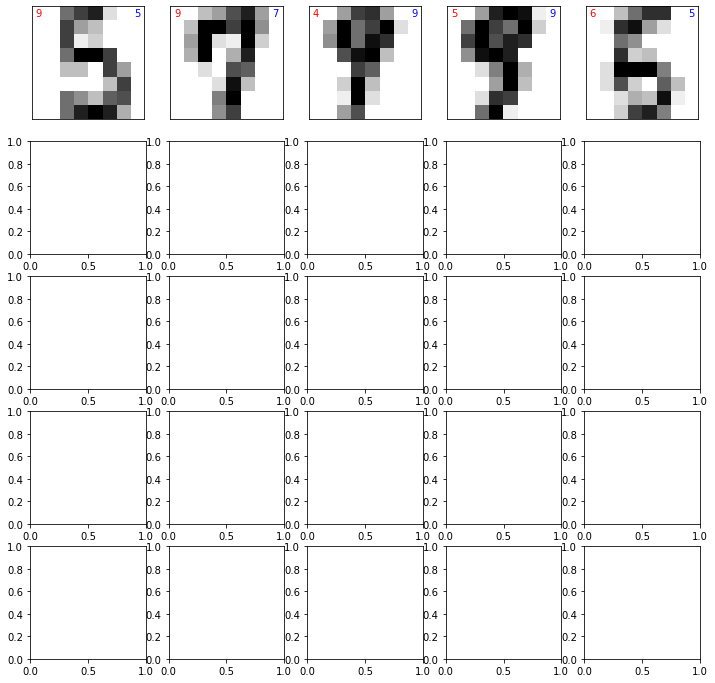

In [44]:
mostar_resultados(digits,KNeighborsClassifier(),nx=5, ny=5,label = "incorrectos")

A priori estas fallas esperamos que ocurran, pues sino el modelo o sólo está aprendiendo, o simplemente no sirve. Podríamos decir que las fallas ocurren por la calidad de los datos que describen a las imágenes. No obstante, el modelo sigue prediciendo bastante bien con respecto a las fallas que obtiene.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Me parece bastante raro que utilizando KNN como mejor predictor tuviese que reducir la dimensionalidad usando PCA, pues en ese sentido se 'pierde' el uso de KNN, ya que le estamos quitando vecinos a los datos. Sin embargo, el modelo y las métricas que empleamos aseguran una rápida convergencia y los errores no son marginalmente amplios, por lo cual podemos decir que el modelo es eficiente para el procesamiento de imágenes y su clasificación en dígitos. 

Las dificultades de este problema es que estamos en una línea muy delgada entre el overfitting y un buen modelo, por eso es sumamente importante analizar las métricas y las distintas curvas, para desestimar esos problemas o, en su defecto, emplear otro modelo.

Un trabajo futuro sería ver si otros métodos como Condensed KNN o Quadratic Discriminant Analysis, métodos embedidos, etc., pueden aportar algo al problema.